## Семинар 7: "Методы оптимизации"

ФИО: Шахвалиева Юлиана Сергеевна

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
from IPython.display import clear_output
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(10, 10))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):   
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)
    
    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

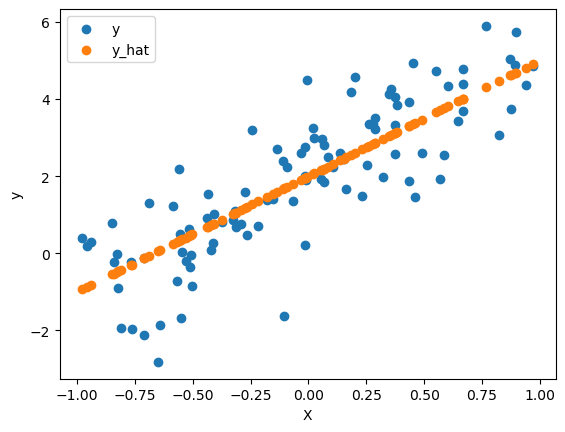

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

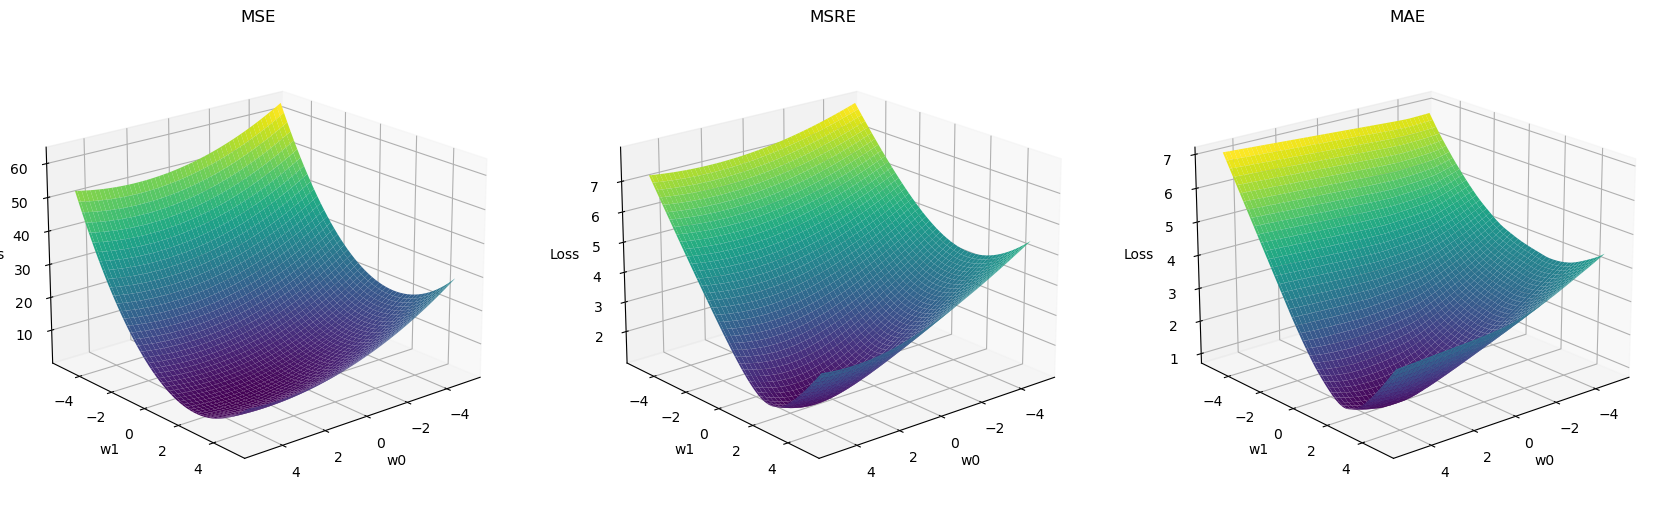

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуйте методы SGD, Momentum, NAG, Adagrad, Adadelta, Adam.</i> **(1 балл)**

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }
    
    return loss_animator.animate(num_iter, data, step_skip=step_skip)

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.v = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.v[i] = self.gamma * self.v[i] + self.lr * p.grad
                p -= self.v[i]

In [110]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            prev_grad = self.params[0].grad
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.v[i] = self.gamma * self.v[i] + self.lr * prev_grad
                p -= self.v[i]
                prev_grad = p.grad

In [165]:
class Adagrad(Optimizer):
    def __init__(self, params, lr=1e-1, eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.eps = eps
        self.G = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += torch.square(p.grad)
                p -= (self.lr / torch.sqrt(self.G[i] + self.eps)) * p.grad

In [166]:
class Adadelta(Optimizer):
    def __init__(self, params, lr=1e-1, gamma=0.9, eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.G = [torch.zeros_like(p) for p in self.params]
        self.D = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * p.grad ** 2
                delta = torch.sqrt(self.D[i] + self.eps) / torch.sqrt(self.G[i] + self.eps) * p.grad
                self.D[i] = self.gamma * self.D[i] + (1 - self.gamma) * delta ** 2
                p -= self.lr * delta

In [167]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-1, betta_1=0.9, betta_2=0.9, eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.betta_1 = betta_1
        self.betta_2 = betta_2
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.m[i] = self.betta_1 * self.m[i] + (1 - self.betta_1) * p.grad
                self.v[i] = self.betta_2 * self.v[i] + (1 - self.betta_2) * p.grad ** 2
                m = self.m[i] / (1 - self.betta_1)
                v = self.v[i] / (1 - self.betta_2)
                p -= self.lr / (torch.sqrt(v)  + self.eps) * m

<i1> 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [103]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), SGD, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)
print(points[-1])

tensor([3.0243, 2.0041])


In [121]:
points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), Momentum, {'lr': 1e-1, 'gamma': 0.8}, start_point=[-20, -20], num_iter=100)
print(points[-1])

tensor([3.1384, 2.0102])


In [122]:
points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), NAG, {'lr': 1e-1, 'gamma': 0.7}, start_point=[-20, -20], num_iter=100)
print(points[-1])

tensor([3.1381, 2.0100])


In [168]:
points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), Adagrad, {'lr': 4, 'eps': 1e-8}, start_point=[-20, -20], num_iter=100)
print(points[-1])

tensor([3.1356, 2.0084])


In [169]:
points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), Adadelta, {'lr': 1.5, 'gamma': 0.6, 'eps': 1e-2}, start_point=[-20, -20], num_iter=100)
print(points[-1])

tensor([3.1190, 2.2182])


In [170]:
points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), Adam, {'lr': 2e-1, 'betta_1': 0.915, 'betta_2': 0.97, 'eps': 1e-3}, start_point=[-20, -20], num_iter=100)
print(points[-1])

tensor([3.5993, 2.2887])


In [182]:
compare_optimizers(loss_animator, mse, [
                                        ('SGD', SGD, {'lr': 1.5e-1}), 
                                        ('Momentum', Momentum, {'lr': 1e-1, 'gamma': 0.8}),
                                        ('NAG', NAG, {'lr': 1e-1, 'gamma': 0.7}),
                                        ('Adagrad', Adagrad, {'lr': 4, 'eps': 1e-8}),
                                        ('Adadelta', Adadelta, {'lr': 1.5, 'gamma': 0.6, 'eps': 1e-2}),
                                        ('Adam', Adam, {'lr': 2e-1, 'betta_1': 0.915, 'betta_2': 0.97, 'eps': 1e-3})
],
                   start_point=[-20, -20], num_iter=100, step_skip = 1)

C:\Software\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
C:\Software\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


На графике ошибке видно, что методы SGD, Momentum, NAG, Adagrad достаточно быстро спустились к минимуму, им понадобилось 10-20 эпох. Оставшимся двум методам: Adadelta и Adam потребовалось значительно больше времени (около 60 эпох) для достижения минимума. Тем не менее, все методы в итоге нашли минимумы. 

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i> **(2 балла)**

In [151]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [128]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [220]:
def train(network, epochs, optimizer):
    loss = nn.NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train')
            plt.plot(test_accuracy_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass
    return test_loss_epochs, test_accuracy_epochs

In [230]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(784, 100),
                                    nn.ReLU(),
                                    nn.Linear(100, 100), 
                                    nn.ReLU(),
                                    nn.Linear(100, 10),
                                    nn.Flatten(),
                                    nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)
    

Epoch 4... (Train/Test) NLL: 0.126/0.123	Accuracy: 0.963/0.962


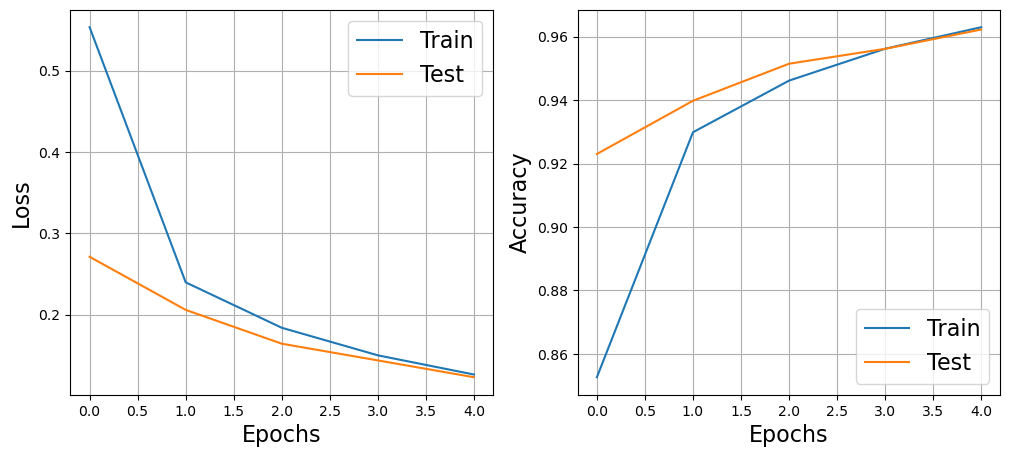

In [231]:
linear_net_sgd = LinearClassifier()
test_loss_sgd, test_accuracy_sgd = train(linear_net_sgd, 5, SGD(linear_net_sgd.parameters(), lr=1e-2))

Epoch 4... (Train/Test) NLL: 0.066/0.082	Accuracy: 0.980/0.975


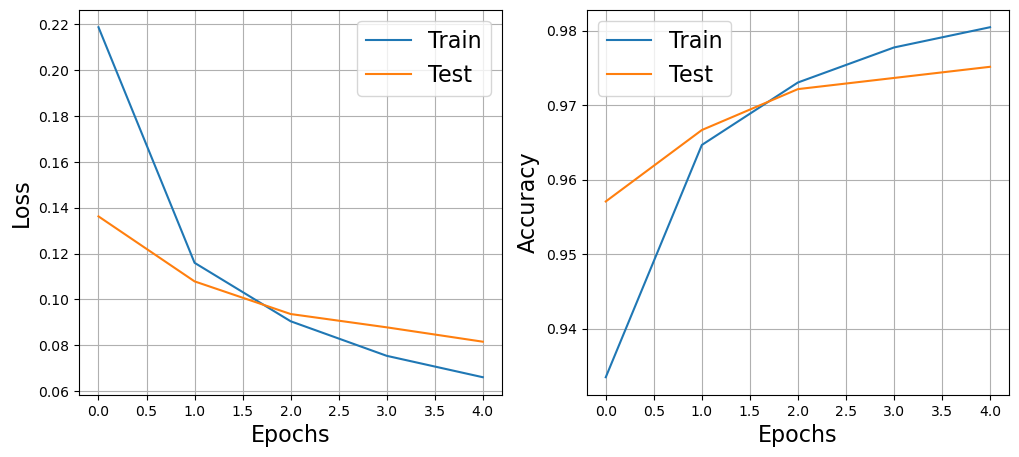

In [236]:
linear_net_adagrad = LinearClassifier()
test_loss_adagrad, test_accuracy_adagrad = train(linear_net_adagrad, 5, Adagrad(linear_net_adagrad.parameters(), lr=1e-2, eps=1e-8))

Epoch 4... (Train/Test) NLL: 0.300/0.280	Accuracy: 0.913/0.918


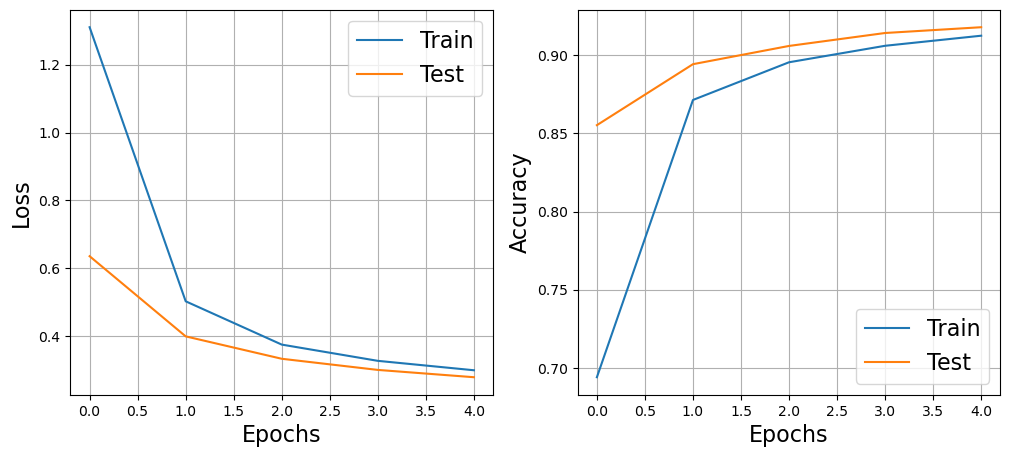

In [233]:
linear_net_adadelta = LinearClassifier()
test_loss_adadelta, test_accuracy_adadelta = train(linear_net_adadelta, 5, Adadelta(linear_net_adadelta.parameters(), lr=1e-1, gamma=0.6))

Epoch 4... (Train/Test) NLL: 0.083/0.094	Accuracy: 0.974/0.971


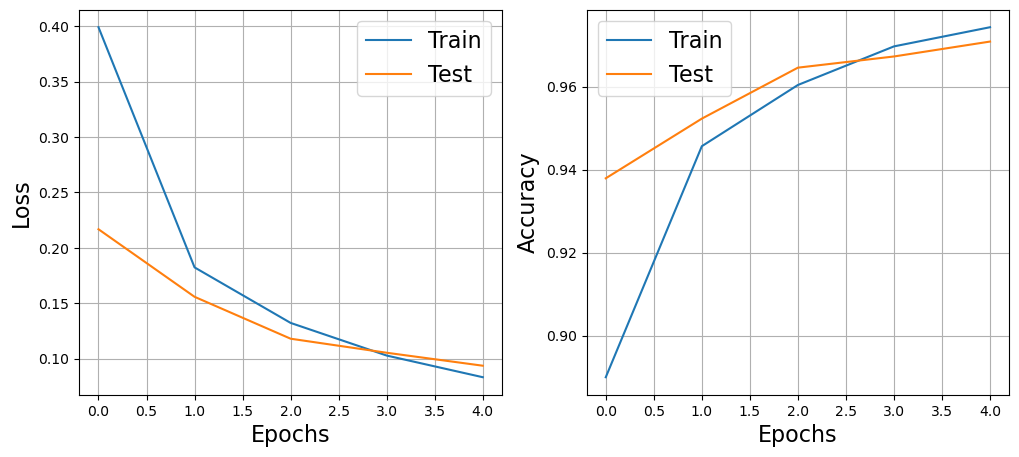

In [234]:
linear_net_adam = LinearClassifier()
test_loss_adam, test_accuracy_adam = train(linear_net_adam, 5, Adam(linear_net_adam.parameters(), lr=1e-4, betta_1=0.915, betta_2=0.97, eps=1e-3))

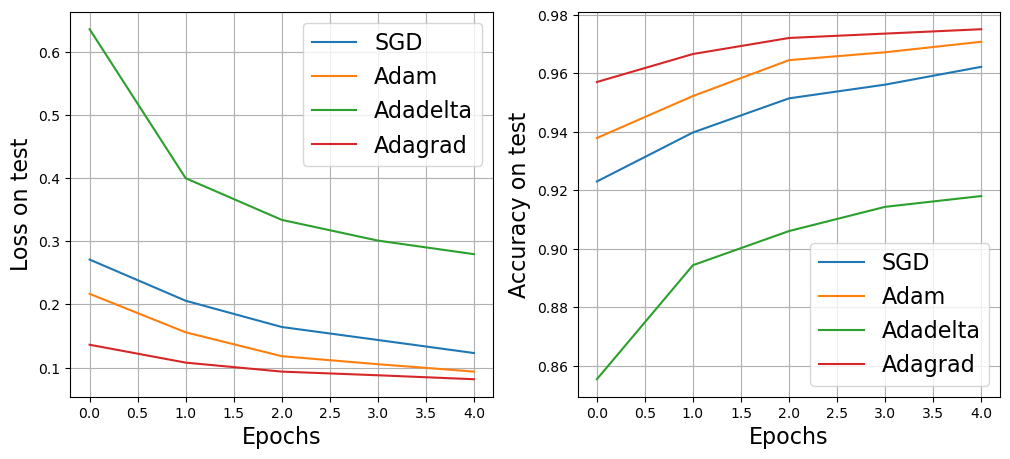

In [238]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_loss_sgd, label='SGD')
plt.plot(test_loss_adam, label='Adam')
plt.plot(test_loss_adadelta, label='Adadelta')
plt.plot(test_loss_adagrad, label='Adagrad')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss on test', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy_sgd, label='SGD')
plt.plot(test_accuracy_adam, label='Adam')
plt.plot(test_accuracy_adadelta, label='Adadelta')
plt.plot(test_accuracy_adagrad, label='Adagrad')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy on test', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Самый лучший результат показал Adagrad (на тестовой выборке 97,5%). Adam показал почти такой же результат: 97,1%. SGD в среднем показывал качество классификации на 1,5% хуже, чем Adam, т.е. прямые этих двух методов оптимизации практически параллельны. Adadelta показал результаты значительно хуже остальных методов оптимизации. Что касается скорости обучения: она достаточно плавная у всех, кроме Adadelta, у этого метода наблюдается значительный скачок на 1 эпохе, после наблюдается плавная оптимизация.

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i> **(1 балл)**

In [129]:
class ConvClassifier(nn.Module):
    def __init__(self, start_channels, image_size):
        super().__init__()
        self.layers = nn.Sequential(*self.get_modules(start_channels, image_size))

    def get_modules(self, start_channels, image_size):
        layers = [
            nn.Conv2d(start_channels, 8, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.Flatten(),
            nn.Linear(image_size // 2 * image_size // 2 * 16 * 2, 10),
            nn.LogSoftmax(dim=1)
        ]

        return layers

    def forward(self, x):
        return self.layers(x)

Epoch 4... (Train/Test) NLL: 0.057/0.054	Accuracy: 0.983/0.981


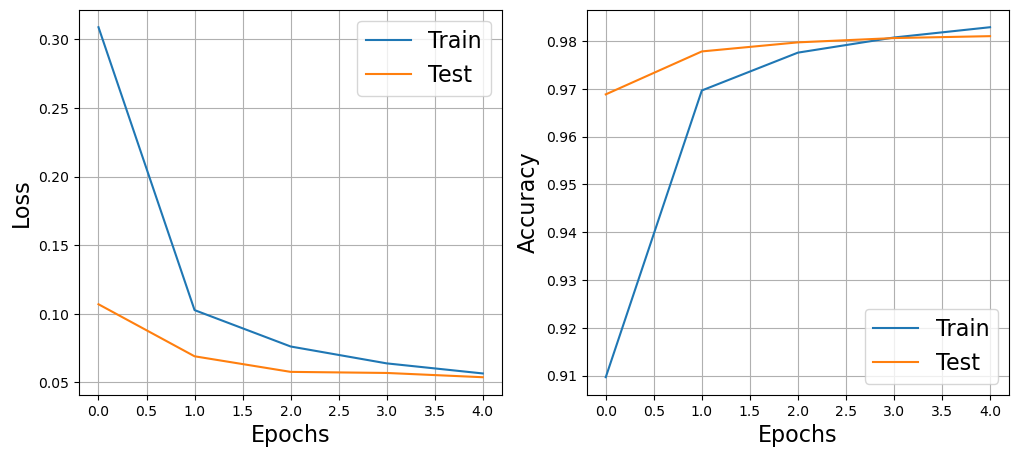

In [159]:
conv_net_sgd = ConvClassifier(start_channels=1, image_size=28)
test_loss_sgd, test_accuracy_sgd = train(conv_net_sgd, 5, SGD(conv_net_sgd.parameters(), lr=1e-2))

Epoch 4... (Train/Test) NLL: 0.104/0.101	Accuracy: 0.968/0.967


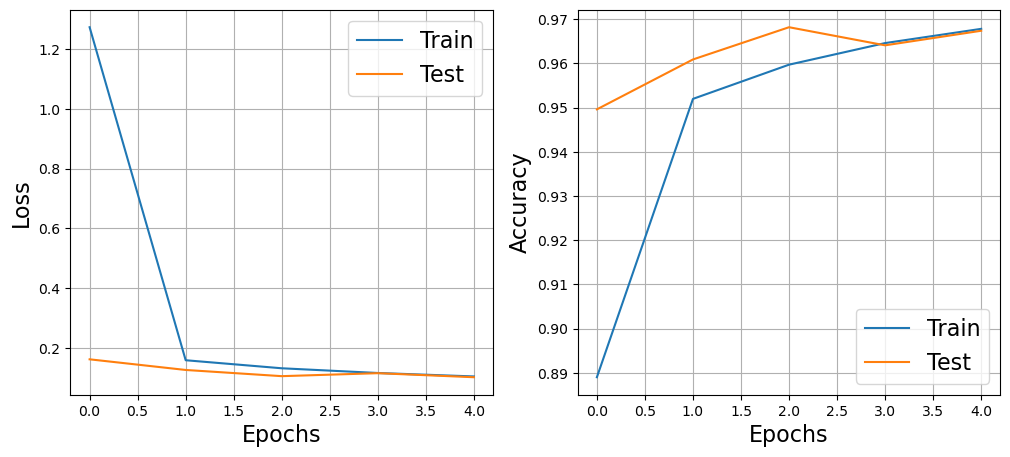

In [186]:
conv_net_adagrad = ConvClassifier(start_channels=1, image_size=28)
test_loss_adagrad, test_accuracy_adagrad = train(conv_net_adagrad, 5, Adagrad(conv_net_adagrad.parameters(), lr=1e-1, eps=1e-8))

Epoch 4... (Train/Test) NLL: 0.273/0.243	Accuracy: 0.921/0.930


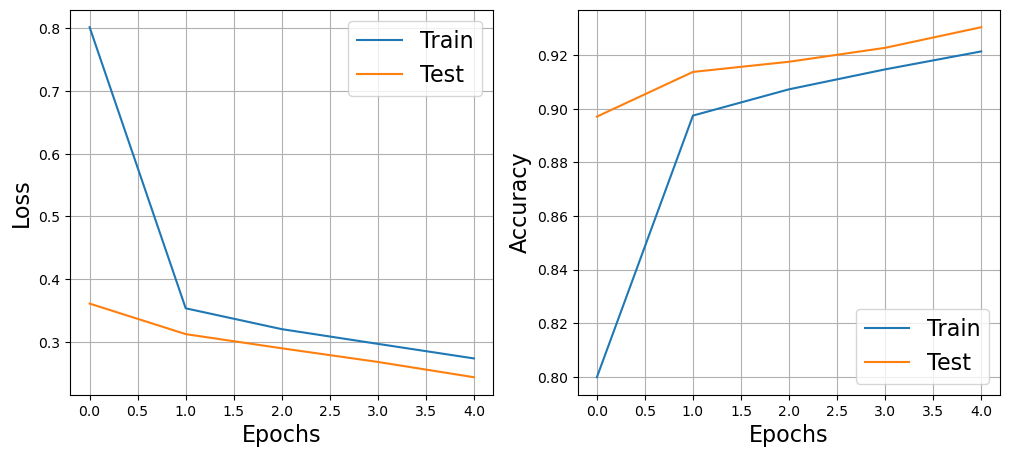

In [183]:
conv_net_adadelta = ConvClassifier(start_channels=1, image_size=28)
test_loss_adadelta, test_accuracy_adadelta = train(conv_net_adadelta, 5, Adadelta(conv_net_adadelta.parameters(), lr=1e-1, gamma=0.6))

Epoch 4... (Train/Test) NLL: 0.047/0.041	Accuracy: 0.986/0.986


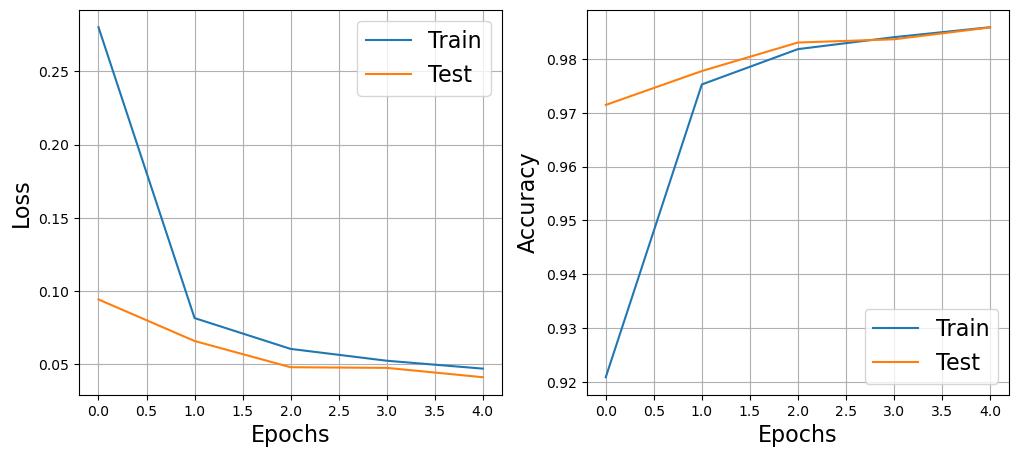

In [189]:
conv_net_adam = ConvClassifier(start_channels=1, image_size=28)
test_loss_adam, test_accuracy_adam = train(conv_net_adam, 5, Adam(conv_net_adam.parameters(), lr=1e-4, betta_1=0.915, betta_2=0.97, eps=1e-3))

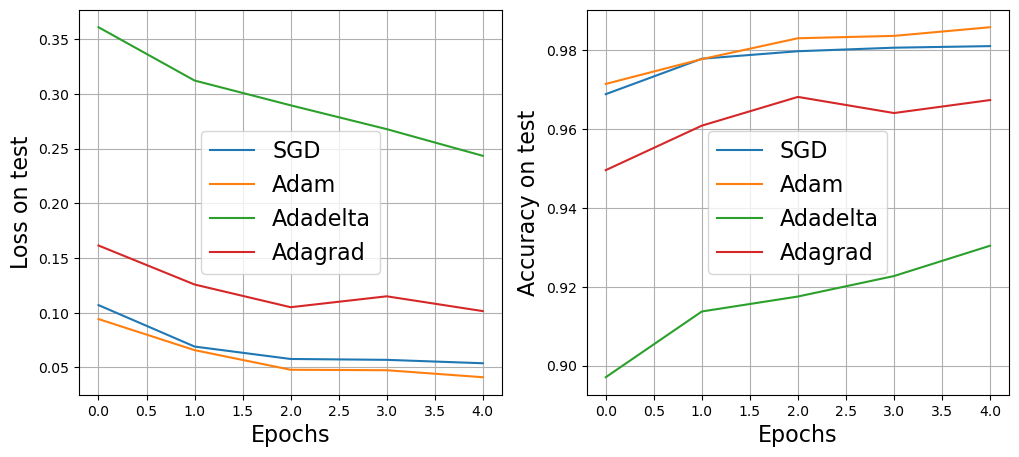

In [190]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_loss_sgd, label='SGD')
plt.plot(test_loss_adam, label='Adam')
plt.plot(test_loss_adadelta, label='Adadelta')
plt.plot(test_loss_adagrad, label='Adagrad')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss on test', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy_sgd, label='SGD')
plt.plot(test_accuracy_adam, label='Adam')
plt.plot(test_accuracy_adadelta, label='Adadelta')
plt.plot(test_accuracy_adagrad, label='Adagrad')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy on test', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Самые лучшие результаты показали Adam и SGD, кривые этих методов оптимизации очень близки друг к другу, тем не менее Adam показал чуть более высокое качество классификации (98,6% на тестовой выборке). Adagrad в среднем показывал качество классификации на 2% хуже, чем первые два метода. Метод оптимизации Adadelta показал самые низкие результаты. Скорость сходимости у всех методов более менее похожая: наблюдается резкий скачок на 1 эпохе, а потом плавное снижение ошибки (повышение качества классификации).

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: